# Model iterations to predict the price of a home based on certain features

## The Business Problem

Phil and Nancy are partners own a house in King County and are looking to renovate their home in order to maximize the value of their home. They have some spare money and have come to the AA Consulting Agency to seek advice on what they should renovate in their house in order to maximize the resale value. They are looking to renovate their house with the intention of flipping it to make a profit and move into a bigger house somewhere else in King County. Our analysis is aimed to help them decide which features to renovate and by how much their home value will increase. Our statistical analysis is aimed to predict home price based on certain renovations. We will test which renovations have the biggest impact on price, and create a predictive model which can help them make an informed data-driven decision. 

This data was pulled from the King County government website and outlines home prices along with other features of the home in a csv file. We will be importing the file into two dateframes for use in the analysis. The data is generally clean, but contains zip codes from locations outside of King County, so we will be removing those as they are not relevant to the data. The address, lat, and long fields were gathered using a third party geocoding API, which explains why there was some discrepency. 

In [1092]:
# imports for libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
import statsmodels.api as sm
import sklearn.linear_model as lm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

## Define Functions

In [1093]:
def stats_test(data,X_main,y_main):
            
    """
    Define a function that can take in a dataframe (data), iterate through each column (X_main,) \
    and conduct a simple linear regression against y (y_main). Train, test split is done, the data is scaled\
    since this only works for numerics. The output is a dataframe with all the features in the rows, and \
    statistical tests in the columns. An OLS summary is also printed for each column being iterated, but is commented out.\
    
    Parameters
        ----------
        data = a numeric df
        X_main = features to test: independent variable
        y_main = feature being measured: dependent variable

        Returns
        -------
        df of stats measures for each feature

    """

    df = pd.DataFrame(columns = ["R_squared", "MSE", "Coef", "Intercept"])
    for i in X_main:
        X = data[[i]]
        y = data[[y_main]]

        # train test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state = 42)
        
        # scale the data to normalize and fit
        scaler = StandardScaler()
        scaler.fit(X_train,y_train)

        # transform
        y_train_scaled = scaler.transform(y_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # form dataframes for test and train data
        X_train_scaled = pd.DataFrame(X_train_scaled,
                                    columns=X_train.columns,
                                    index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled,
                                    columns=X_test.columns,
                                    index=X_test.index)
        
        # instantiate a sk.learn simple linear model
        model= LinearRegression()
        model.fit(X_train_scaled, y_train)

        # conduct stats tests
        expected = np.array(y_test)
        predicted= model.predict(X_test_scaled)
        mse = int(sum((expected - predicted)**2))
        r2 = model.score(X_train_scaled, y_train)
        coef = float(model.coef_)
        intercept = model.intercept_

        # create columns with stats variables
        df.loc[len(df.index)+1] = [r2, mse, coef, intercept]
        #model_OLS = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
        #print(model_OLS.summary())

    # set row names to correspond and reset index
    df[y_main] = X_main
    df.set_index([y_main], drop=True, inplace=True)
    df = df.reset_index()

    return df


In [1094]:
# all variables vs all variables and find highest R
def correlate(data):
    """
    Params:
    dataframe to be iterated with stats test
    Output = dictionary with dependent variables as a key to a dictionary with the independent variable and corresponding r2
    """
    highest_R = {}
    for i in data.columns:
        y = i
        model_cols = list(data.drop(columns = y, axis=1).columns)
        X_df = stats_test(data,model_cols,y)
        highest_R.update({y: {X_df.iloc[int(X_df.loc[X_df["R_squared"] == X_df["R_squared"].max()].index[0])][0]\
                            : X_df["R_squared"].max()}})
    
    return highest_R

In [1095]:
def MSE(data):
    """
    Params: 
    dataframe which will be iterated for a stats test

    Output = dictionary with dependent variables as the key to a dict with the least error variable and its corresponding error
    """
    MSE_lowest = {}
    for i in data.columns:
        y = i
        model_cols = list(data.drop(columns = y, axis=1).columns)
        X_df = stats_test(data,model_cols,y)
        MSE_lowest.update({y: {X_df.iloc[int(X_df.loc[X_df["MSE"] == X_df["MSE"].min()].index[0])][0]\
                            : X_df["MSE"].min()}})
        
    return MSE_lowest

# Data prep

Creating two dataframes because I tried one method of breaking out the df_base into two dateframes, categorical vs. numeric and then remerge them later to predict a base model, however this method is not very helpful. The df is assigned to be used later in the code for iterations on the final model.

In [1096]:
df_base = pd.read_csv('data/kc_house_data.csv', index_col=0).drop_duplicates() # (30155,25), 3 duplicated entries
df = pd.read_csv('data/kc_house_data.csv', index_col=0).drop_duplicates() # (30155,25), 3 duplicated entries
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30152 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30152 non-null  object 
 1   price          30152 non-null  float64
 2   bedrooms       30152 non-null  int64  
 3   bathrooms      30152 non-null  float64
 4   sqft_living    30152 non-null  int64  
 5   sqft_lot       30152 non-null  int64  
 6   floors         30152 non-null  float64
 7   waterfront     30152 non-null  object 
 8   greenbelt      30152 non-null  object 
 9   nuisance       30152 non-null  object 
 10  view           30152 non-null  object 
 11  condition      30152 non-null  object 
 12  grade          30152 non-null  object 
 13  heat_source    30120 non-null  object 
 14  sewer_system   30138 non-null  object 
 15  sqft_above     30152 non-null  int64  
 16  sqft_basement  30152 non-null  int64  
 17  sqft_garage    30152 non-null  int64

Heatmap of all attributes in the df_base

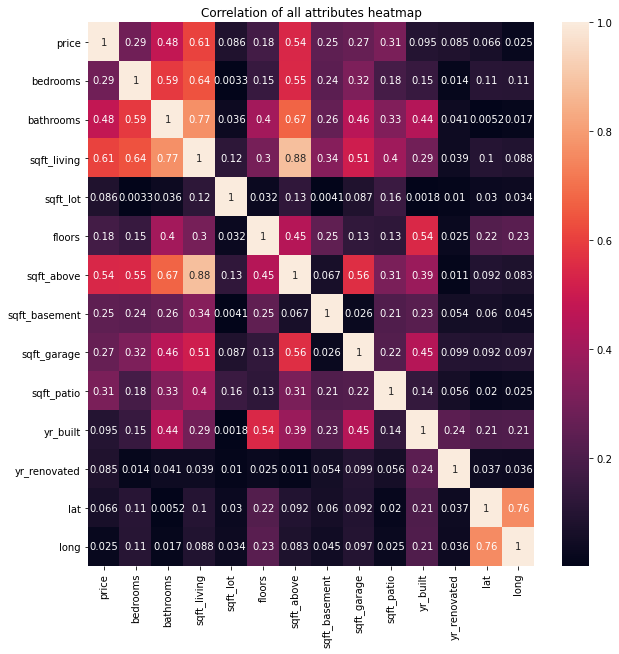

In [1097]:
# will need to dig into collinear relationships and normalize some of these features
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(abs(df_base.corr()),annot=True).set(title = "Correlation of all attributes heatmap");
plt.savefig('imgs/heatmap_1.png')

Make a numeric dataframe by selecting integers and floats

In [1098]:
numeric_df = df_base.select_dtypes([int,float])
numeric_df = numeric_df.reset_index()
numeric_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
0,7399300360,675000.0,4,1.0,1180,7140,1.0,1180,0,0,40,1969,0,47.461975,-122.19052
1,8910500230,920000.0,5,2.5,2770,6703,1.0,1570,1570,0,240,1950,0,47.711525,-122.35591
2,1180000275,311000.0,6,2.0,2880,6156,1.0,1580,1580,0,0,1956,0,47.502045,-122.22520
3,1604601802,775000.0,3,3.0,2160,1400,2.0,1090,1070,200,270,2010,0,47.566110,-122.29020
4,8562780790,592500.0,2,2.0,1120,758,2.0,1120,550,550,30,2012,0,47.532470,-122.07188


Make a categorical dataframe by selecting objects

In [1099]:
cat_df = df_base.select_dtypes(object)
cat_df = cat_df.reset_index()
cat_df.head()

,id,date,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,address
0,7399300360,5/24/2022,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,"2102 Southeast 21st Court, Renton, Washington ..."
1,8910500230,12/13/2021,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,"11231 Greenwood Avenue North, Seattle, Washing..."
2,1180000275,9/29/2021,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,"8504 South 113th Street, Seattle, Washington 9..."
3,1604601802,12/14/2021,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,"4079 Letitia Avenue South, Seattle, Washington..."
4,8562780790,8/24/2021,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,"2193 Northwest Talus Drive, Issaquah, Washingt..."


# Categorical EDA

In [1100]:
# cleaning categorical features
zips = []
street_name = []

# make the address data useable
for i in cat_df["address"]:
    # create variable to store partitioned strings from address column
    # first will be used in certain iterations
    info = i.split(",")
    first = info[0].split(" ")

    # store variables in appropriate lists
    zips.append(info[-2][-5:])
    street_name.append(" ".join(first[1:len(first)]))

# create columns from the lists in the cat_df
cat_df["zipcode"] = zips
cat_df["street_name"] = street_name

# remove zips codes outside King County
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = [x.split()[0] for x in ci_zips]
cat_df = cat_df.loc[[(i in ci_zips) for i in cat_df['zipcode'].values]]

#remove irrelevant features
cat_df = cat_df.drop(columns=['date', 'address'])

cat_df.head()

,id,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,zipcode,street_name
0,7399300360,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,98055,Southeast 21st Court
1,8910500230,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,98133,Greenwood Avenue North
2,1180000275,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,98178,South 113th Street
3,1604601802,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,98118,Letitia Avenue South
4,8562780790,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,98027,Northwest Talus Drive


In [1101]:
# check for nulls
cat_df.isna().sum().sum()

42

In [1102]:
# drop nulls
cat_df = cat_df.dropna()

In [1103]:
# show column names
list(cat_df.columns)

['id',
 'waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'condition',
 'grade',
 'heat_source',
 'sewer_system',
 'zipcode',
 'street_name']

## Encoding the relevant columns

In [1104]:
# columns of interest (will be iterated) = ['waterfront','greenbelt', "nuisance", "view", "condition", "grade", "heat_source", "sewer_system", "zips", "year_int", "city"]
onehot_enc = OneHotEncoder(drop = 'first', sparse = False)
nominal_cols =  ['waterfront','greenbelt','nuisance','view','condition','grade','heat_source','sewer_system','zipcode']
x=onehot_enc.fit_transform(cat_df[nominal_cols])
names = list(onehot_enc.get_feature_names())
len(names)


106

## Create an encoded df with better named features

In [1105]:
# encoded to df
enc_cat_df = pd.DataFrame(x)
# make a dict of names
names_dict = {i:names[i] for i in range(0,len(names))}
# rename the columns in the new df
enc_cat_df = enc_cat_df.rename(columns=names_dict)
enc_cat_df.head()

,x0_YES,x1_YES,x2_YES,x3_EXCELLENT,x3_FAIR,x3_GOOD,x3_NONE,x4_Fair,x4_Good,x4_Poor,...,x8_98155,x8_98166,x8_98168,x8_98177,x8_98178,x8_98188,x8_98198,x8_98199,x8_98224,x8_98288
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Numeric EDA

Heatmap of all attributes in the numeric_df

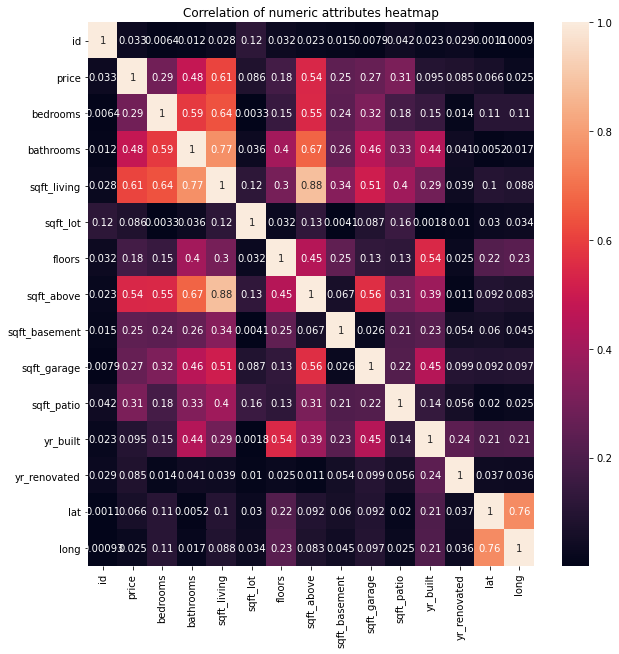

In [1106]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(abs(numeric_df.corr()),annot=True).set(title = "Correlation of numeric attributes heatmap");

## Finding what correlates best with any permutation of features

In [1107]:
# single variable test for one dependent variable vs other features for numeric df
y = "price"
model_cols = list(numeric_df.drop(columns = y, axis=1).columns)
X_df = stats_test(numeric_df,model_cols,y)
X_df.sort_values(by="R_squared", ascending=False)

,price,R_squared,MSE,Coef,Intercept
3,sqft_living,0.362990,2786845826296059,540530.269019,[1105168.26491439]
6,sqft_above,0.285664,3225125675938817,479513.393154,[1105168.26491439]
2,bathrooms,0.222878,3457081874006902,423551.349963,[1105168.26491439]
9,sqft_patio,0.096227,4211345252806321,278305.703985,[1105168.26491439]
1,bedrooms,0.080313,4246558550842999,254252.784607,[1105168.26491439]
8,sqft_garage,0.069508,4368094804259179,236532.451119,[1105168.26491439]
7,sqft_basement,0.057804,4384464355696713,215701.338377,[1105168.26491439]
5,floors,0.030839,4537066294534626,157552.687801,[1105168.26491439]
10,yr_built,0.008825,4668274815767883,84281.483947,[1105168.26491439]
11,yr_renovated,0.007502,4687753142686419,77708.533302,[1105168.26491439]


In [1108]:
# changing all values to floats for numeric df for merge
numeric_df = numeric_df.applymap(float)

# EDA for merged dataframe

## Merge Numeric and Categorical dataframe

In [1109]:
num_cat_df = numeric_df.join(enc_cat_df, how='inner')
num_cat_df = num_cat_df.drop(columns="id")
num_cat_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,...,x8_98155,x8_98166,x8_98168,x8_98177,x8_98178,x8_98188,x8_98198,x8_98199,x8_98224,x8_98288
0,675000.0,4.0,1.0,1180.0,7140.0,1.0,1180.0,0.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,920000.0,5.0,2.5,2770.0,6703.0,1.0,1570.0,1570.0,0.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,311000.0,6.0,2.0,2880.0,6156.0,1.0,1580.0,1580.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,775000.0,3.0,3.0,2160.0,1400.0,2.0,1090.0,1070.0,200.0,270.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,592500.0,2.0,2.0,1120.0,758.0,2.0,1120.0,550.0,550.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1110]:
# count nulls
num_cat_df.isna().sum().sum()

0

Text(0.5, 1.0, 'Distribution of Home Sale Prices in King County')

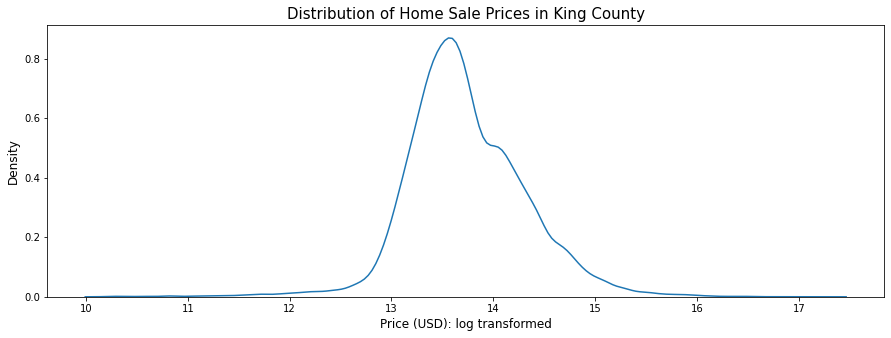

In [1111]:
# quick visual of price distribution
fig, ax = plt.subplots(figsize=(15, 5))
sns.kdeplot(np.log(num_cat_df["price"]),ax=ax)
ax.set_xlabel("Price (USD): log transformed", size = 12 )
ax.set_ylabel("Density", size = 12)
ax.set_title("Distribution of Home Sale Prices in King County", size = 15)

# Data cleaning

Trying to tackle collinearity between some of the various square footage features by merging them into sqft_home.

In [1112]:
num_cat_df["sqft_home"] = (num_cat_df['sqft_above'] + num_cat_df['sqft_basement'] + num_cat_df['sqft_garage'] + num_cat_df['sqft_patio'])
num_cat_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,...,x8_98166,x8_98168,x8_98177,x8_98178,x8_98188,x8_98198,x8_98199,x8_98224,x8_98288,sqft_home
0,675000.0,4.0,1.0,1180.0,7140.0,1.0,1180.0,0.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1220.0
1,920000.0,5.0,2.5,2770.0,6703.0,1.0,1570.0,1570.0,0.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3380.0
2,311000.0,6.0,2.0,2880.0,6156.0,1.0,1580.0,1580.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3160.0
3,775000.0,3.0,3.0,2160.0,1400.0,2.0,1090.0,1070.0,200.0,270.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2630.0
4,592500.0,2.0,2.0,1120.0,758.0,2.0,1120.0,550.0,550.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2250.0


In [1113]:
# drop the reallocated columns
num_cat_df = num_cat_df.drop(columns=["sqft_above", "sqft_basement", "sqft_garage", "sqft_patio"])

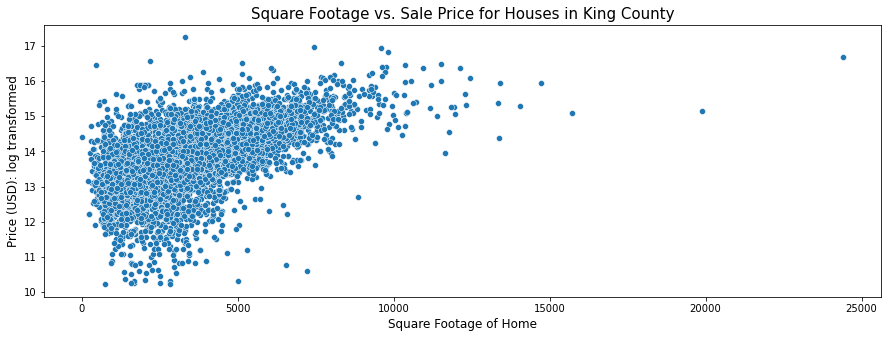

In [1114]:
# quick visual of sqft_home distribution

fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x=(num_cat_df["sqft_home"]),y=np.log(num_cat_df["price"]))
ax.set_xlabel("Square Footage of Home", size = 12 )
ax.set_ylabel("Price (USD): log transformed", size = 12)
ax.set_title("Square Footage vs. Sale Price for Houses in King County", size = 15);

Dropping the outlier for sqft_home

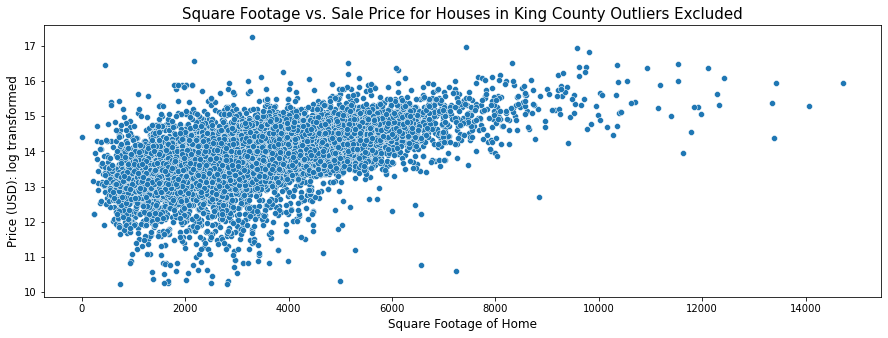

In [1115]:
num_cat_df = num_cat_df.drop(num_cat_df.loc[num_cat_df["sqft_home"] > 15000.0].index)
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x=(num_cat_df["sqft_home"]),y=np.log(num_cat_df["price"]))
ax.set_xlabel("Square Footage of Home", size = 12 )
ax.set_ylabel("Price (USD): log transformed", size = 12)
ax.set_title("Square Footage vs. Sale Price for Houses in King County Outliers Excluded", size = 15);
plt.savefig('imgs/sqft_house_12.png')

Year renovated might be better to encode into a binary value since only some homes have been renovated and the majority are not. 0 for not renovated and 1 for renovated might fix the data

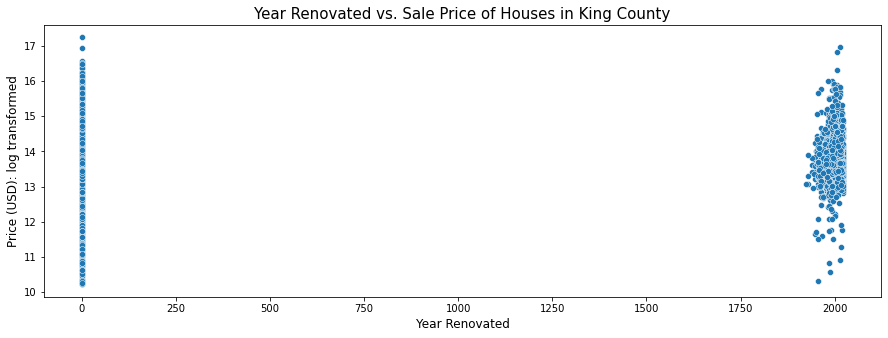

In [1116]:
# quick visual of yr_renovated 
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x=(num_cat_df["yr_renovated"]),y=np.log(num_cat_df["price"]))
ax.set_xlabel("Year Renovated", size = 12 )
ax.set_ylabel("Price (USD): log transformed", size = 12)
ax.set_title("Year Renovated vs. Sale Price of Houses in King County", size = 15);

In [1117]:
# Encoding manually into a binary value and making a new column called renovated. I then drop the yr_renovated column.
num_cat_df["renovated"] = [1.0 if x != 0 else 0.0 for x in num_cat_df["yr_renovated"]]
num_cat_df = num_cat_df.drop(columns="yr_renovated")

Visualizing sqft_lot shows several extreme outliers which I will get rid of

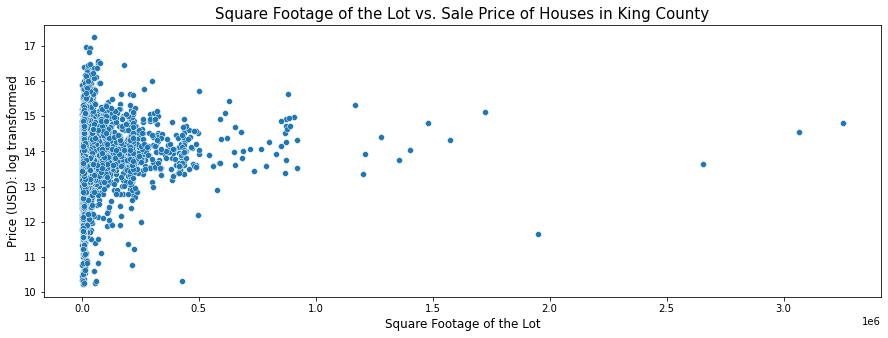

In [1118]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x=(num_cat_df["sqft_lot"]),y=np.log(num_cat_df["price"]))
ax.set_xlabel("Square Footage of the Lot", size = 12 )
ax.set_ylabel("Price (USD): log transformed", size = 12)
ax.set_title("Square Footage of the Lot vs. Sale Price of Houses in King County", size = 15);

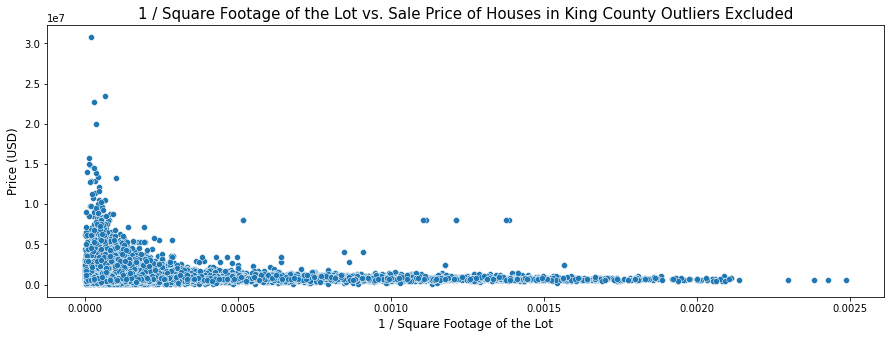

In [1119]:
# dropping the outliers and trying to map the inverse of sqft_lot but it does not help
num_cat_df = num_cat_df.drop(num_cat_df.loc[num_cat_df["sqft_lot"] > 1500000].index)

fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(x=1/(num_cat_df["sqft_lot"]),y=(num_cat_df["price"]))
ax.set_xlabel("1 / Square Footage of the Lot", size = 12 )
ax.set_ylabel("Price (USD)", size = 12)
ax.set_title("1 / Square Footage of the Lot vs. Sale Price of Houses in King County Outliers Excluded", size = 15);

# Making a baseline model

## Testing the price feature to see what is most correlated with price

The more features we include, the more useful the model becomes

In [1120]:
# using a single regression test to iterate over each feature and correlate with price in a train test split
# this outputs a table with price as the index, and the R squared for each feature in a single regression test
# the MSE is the prediction of the mean squared error for each model
y_main= "price"
to_drop = [y_main]
model_cols = list(num_cat_df.drop(columns=to_drop, axis=1).columns)
X_df = stats_test(num_cat_df,model_cols,y_main)
tester = X_df.sort_values(by="R_squared", ascending=False)
tester

,price,R_squared,MSE,Coef,Intercept
2,sqft_living,3.604293e-01,2576693860626378,542172.089651,[1105651.711337995]
114,sqft_home,3.339471e-01,2689695811860759,521874.296641,[1105651.711337995]
1,bathrooms,2.231627e-01,3236045962159449,426616.761720,[1105651.7113379948]
0,bedrooms,8.084875e-02,3948214562800953,256781.512033,[1105651.711337995]
4,floors,3.084992e-02,4207287460977704,158618.611041,[1105651.711337995]
...,...,...,...,...,...
36,x7_PRIVATE RESTRICTED,2.726538e-08,4369034873531488,149.118967,[1105651.711337995]
109,x8_98188,1.989919e-08,4369109066922824,-127.392759,[1105651.711337995]
106,x8_98168,1.628460e-08,4369102103887479,-115.243301,[1105651.711337995]
20,x5_12 Luxury,6.088457e-09,4369090892136780,70.466179,[1105651.711337995]


Generate a list of test names to be tested in the multiple regression model

In [1121]:
test_names = [i for i in tester[y_main]]

Conduct a multiple regression test with all features that have been selected in the test_names list

In [1122]:
X = num_cat_df[test_names]
y = np.log(num_cat_df[[y_main]])

# form dataframes for test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
# scale the data to normalize and fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# form dataframes for test and train data
X_train_scaled = pd.DataFrame(X_train_scaled,
                            columns=X_train.columns,
                            index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,
                            columns=X_test.columns,
                            index=X_test.index)
        
# instantiate a sk.learn simple linear model
model= LinearRegression()
model.fit(X_train_scaled, y_train)

# conduct stats tests
expected = np.array(y_test)
predicted= model.predict(X_test_scaled)
mse = int(sum((np.exp(expected) - np.exp(predicted))**2))
r2 = model.score(X_train_scaled, y_train)
#coef = float(model.coef_)
intercept = model.intercept_

# create columns with stats variables
model_OLS = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
print(model_OLS.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     147.7
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:59:16   Log-Likelihood:                -14089.
No. Observations:               23311   AIC:                         2.841e+04
Df Residuals:                   23195   BIC:                         2.934e+04
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    13.73

Summary analysis: sqft_living has one of the strongest coefficients in this model. For each incremental increase in sqft_living the log(price) increases by 0.2508. If all other features are kept constant, the price of the home will be incremented by e^2 13.7322 (as compared to the price increment of a less expensive zipcode). 

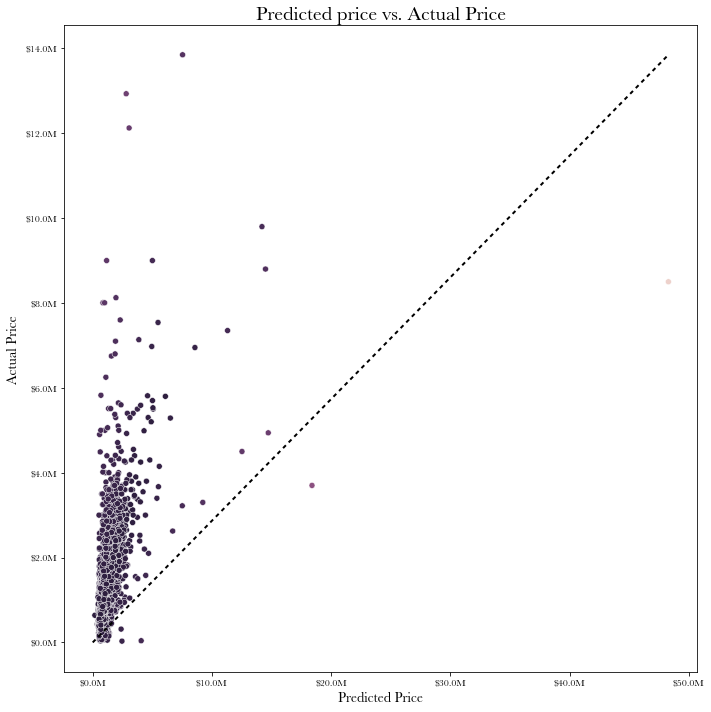

In [1123]:
# plot the residuals from the test
predicted = np.exp(predicted)
expected = np.exp(expected)

fig, ax = plt.subplots(figsize=(10, 10))
# sns.jointplot(x= 'actual',y= 'resid', data=y_df).set()
sns.scatterplot(x=predicted.flatten(),y=expected.flatten(), hue=-np.abs(predicted-expected).flatten())
ax.legend([],[], frameon=False)
plt.xlabel('Predicted Price', fontdict={'fontfamily':'Baskerville',
                                        'fontsize':14,
                                        'fontweight':'bold'})
plt.ylabel('Actual Price', fontdict={'fontfamily':'Baskerville',
                                     'fontsize':14,
                                     'fontweight':'bold'})
plt.title('Predicted price vs. Actual Price', fontdict={'fontfamily':'Baskerville',
                                                        'fontsize':20,
                                                        'fontweight':'bold'})
plt.xticks(fontfamily='Baskerville')
plt.yticks(fontfamily='Baskerville')
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
plt.plot([0, max(predicted)], [0, max(expected)], linewidth=2, color='black', dashes=[2,2])
plt.tight_layout()

plt.savefig('imgs/middle_34.png')
plt.show()

## Testing correlations for all features vs all features - 10 min runtime

This was used to find the strongest correlation of each feature vs. each feature. The commented blocks of code take 10 mins to run but feel free to give it a shot with the dataframe of your choice. I used this to determine where the signals are in the data and what we should correlate against what in the model. 

In [1124]:
# output_R2 = correlate(num_cat_df)

In [1125]:
# values = []
# for i in output_R2.values():
#     values.append(list(i.values()))

# values.sort(reverse=True)

# count = 20
# keys = {}
# for c in range(0,count):
#     for key, value in output_R2.items():
#         for i in value.values():
#             if values[c][0] == i:
#                 keys.update({key:value})
            

# keys

In [1126]:
# outputMSE = MSE(test_num_cat_df)

In [1127]:
# values = []
# for i in outputMSE.values():
#     values.append(list(i.values()))

# values.sort(reverse=False)

# count = len(outputMSE)
# keys = {}
# for c in range(0,count):
#     for key, value in outputMSE.items():
#         for i in value.values():
#             if values[c][0] == i:
#                 keys.update({key:value})
# keys

# Testing the dataframe with a different approach

## EDA for df

We created two dataframes in the beginning; this section yields stronger results for the model as we did things differently with encoding values. This section helped create the final model which is in Alex's notebook.

In [1128]:
# inspection of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30152 entries, 7399300360 to 9557800100
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           30152 non-null  object 
 1   price          30152 non-null  float64
 2   bedrooms       30152 non-null  int64  
 3   bathrooms      30152 non-null  float64
 4   sqft_living    30152 non-null  int64  
 5   sqft_lot       30152 non-null  int64  
 6   floors         30152 non-null  float64
 7   waterfront     30152 non-null  object 
 8   greenbelt      30152 non-null  object 
 9   nuisance       30152 non-null  object 
 10  view           30152 non-null  object 
 11  condition      30152 non-null  object 
 12  grade          30152 non-null  object 
 13  heat_source    30120 non-null  object 
 14  sewer_system   30138 non-null  object 
 15  sqft_above     30152 non-null  int64  
 16  sqft_basement  30152 non-null  int64  
 17  sqft_garage    30152 non-null  int64

In [1129]:
# find nulls
df.isna().sum()

date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
dtype: int64

In [1130]:
# drop null values
df = df.dropna()
df.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
dtype: int64

In [1131]:
# show the columns
df.columns
# ['bedrooms',
#  'bathrooms',
#  'sqft_living',
#  'sqft_lot',
#  'floors',
#  'waterfront',
#  'greenbelt',
#  'nuisance',
#  'view',
#  'condition',
#  'grade',
#  'zipcode',
#  'sqft_above',
#  'sqft_basement',
#  'sqft_garage',
#  'sqft_patio',
#  'yr_built',
#  'yr_renovated']

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition',
       'grade', 'heat_source', 'sewer_system', 'sqft_above', 'sqft_basement',
       'sqft_garage', 'sqft_patio', 'yr_built', 'yr_renovated', 'address',
       'lat', 'long'],
      dtype='object')

## Data prep for df

In [1132]:
# initiate label encoder for waterfront, greenbelt, and nuisance features
le = LabelEncoder()
le_cols = ['waterfront', 'greenbelt', 'nuisance']
# fit, transform, and apply the encoded values into the df
df[le_cols] = df[le_cols].apply(lambda x: le.fit_transform(x))

Cleaning zipcode again to omit places not in King County

In [1133]:
# cleaning categorical features
zips = []
street_name = []

# make the address data useable
for i in df["address"]:
    # create variable to store partitioned strings from address column
    # first will be used in certain iterations
    info = i.split(",")
    first = info[0].split(" ")

    # store variables in appropriate lists
    zips.append(info[-2][-5:])
    street_name.append(" ".join(first[1:len(first)]))

# create columns from the lists in the cat_df
df["zipcode"] = zips
df["street_name"] = street_name

# remove zips codes outside King County
# https://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?FIPS=53033
ci_zips = ['98002 (Auburn)', '98092 (Auburn)', '98224 (Baring)', '98004 (Bellevue)', '98005 (Bellevue)', '98006 (Bellevue)', '98007 (Bellevue)', '98008 (Bellevue)', '98010 (Black Diamond)', '98011 (Bothell)', '98178 (Bryn Mawr-Skyway)', '98148 (Burien)', '98166 (Burien)', '98014 (Carnation)', '98077 (Cottage Lake)', '98042 (Covington)', '98198 (Des Moines)', '98019 (Duvall)', '98031 (East Hill-Meridian)', '98022 (Enumclaw)', '98058 (Fairwood)', '98024 (Fall City)', '98003 (Federal Way)', '98023 (Federal Way)', '98027 (Issaquah)', '98029 (Issaquah)', '98028 (Kenmore)', '98032 (Kent)', '98030 (Kent)', '98033 (Kirkland)', '98034 (Kirkland)', '98001 (Lakeland North)', '98038 (Maple Valley)', '98039 (Medina)', '98040 (Mercer Island)', '98045 (North Bend)', '98047 (Pacific)', '98050 (Preston)', '98051 (Ravensdale)', '98052 (Redmond)', '98055 (Renton)', '98056 (Renton)', '98057 (Renton)', '98059 (Renton)', '98074 (Sammamish)', '98075 (Sammamish)', '98188 (SeaTac)', '98199 (Seattle)', '98174 (Seattle)', '98154 (Seattle)', '98158 (Seattle)', '98164 (Seattle)', '98101 (Seattle)', '98102 (Seattle)', '98103 (Seattle)', '98104 (Seattle)', '98105 (Seattle)', '98106 (Seattle)', '98107 (Seattle)', '98108 (Seattle)', '98109 (Seattle)', '98112 (Seattle)', '98115 (Seattle)', '98116 (Seattle)', '98117 (Seattle)', '98118 (Seattle)', '98119 (Seattle)', '98121 (Seattle)', '98122 (Seattle)', '98125 (Seattle)', '98126 (Seattle)', '98133 (Seattle)', '98134 (Seattle)', '98136 (Seattle)', '98144 (Seattle)', '98155 (Shoreline)', '98177 (Shoreline)', '98288 (Skykomish)', '98065 (Snoqualmie)', '98168 (Tukwila)', '98053 (Union Hill-Novelty Hill)', '98195 (Univ Of Washington)', '98070 (Vashon)', '98146 (White Center)', '98072 (Woodinville)']
ci_zips = [x.split()[0] for x in ci_zips]
df = df.loc[[(i in ci_zips) for i in df['zipcode'].values]]

#remove irrelevant features
df = df.drop(columns=['date', 'address'])

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode,street_name
id,,,,,,,,,,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,7140,1.0,0,0,0,NONE,...,1180,0,0,40,1969,0,47.461975,-122.19052,98055,Southeast 21st Court
8910500230,920000.0,5,2.5,2770,6703,1.0,0,0,1,AVERAGE,...,1570,1570,0,240,1950,0,47.711525,-122.35591,98133,Greenwood Avenue North
1180000275,311000.0,6,2.0,2880,6156,1.0,0,0,0,AVERAGE,...,1580,1580,0,0,1956,0,47.502045,-122.22520,98178,South 113th Street
1604601802,775000.0,3,3.0,2160,1400,2.0,0,0,0,AVERAGE,...,1090,1070,200,270,2010,0,47.566110,-122.29020,98118,Letitia Avenue South
8562780790,592500.0,2,2.0,1120,758,2.0,0,0,1,NONE,...,1120,550,550,30,2012,0,47.532470,-122.07188,98027,Northwest Talus Drive


Manually encoding the yr_renovated column to be binary as we did in the other df

In [1134]:
df["renovated"] = [1.0 if x != 0 else 0.0 for x in df["yr_renovated"]]
df = df.drop(columns="yr_renovated")

In [1135]:
# adding more features to encode with the label encoder and add into the df
df['condition'] = le.fit_transform(df['condition'])
df['view'] = le.fit_transform(df['view'])
df['grade'] = le.fit_transform(df['grade'])

One hot encoder is used here to create a dataframe which will be plugged into the model after train/test split.

In [1136]:
ohe = OneHotEncoder(sparse = False, handle_unknown= 'ignore')
# encoding zip code and heat source with OHE and placing the values into a seperate dataframe for now
ohe_df = ohe.fit_transform(df[['zipcode', "heat_source"]])
# relabeling the columns to be useful
ohe_df = pd.DataFrame(ohe_df, columns = ohe.get_feature_names())
ohe_df

,x0_98001,x0_98002,x0_98003,x0_98004,x0_98005,x0_98006,x0_98007,x0_98008,x0_98010,x0_98011,...,x0_98199,x0_98224,x0_98288,x1_Electricity,x1_Electricity/Solar,x1_Gas,x1_Gas/Solar,x1_Oil,x1_Oil/Solar,x1_Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
29144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Relevant columns were determined by finding the most useful predictors in the functions I coded in the start of the document. I used "correlate" and "MSE" to find the most relevant and least relevant predictors in the base model.

In [1137]:
# These are the most relevant columns we want to test for in the multiple linear regression model
model_cols = [
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'condition',
 'grade',
 'zipcode',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 "renovated", 
 'yr_built']

# create a model_df which will be used in the test by merging encoded values back into the dataframe
model_df = pd.concat([df[model_cols].reset_index(), ohe_df], 1)

y = df['price'].reset_index()

In [1138]:
# define variables to use for the test
X = model_df[model_cols]
y = np.log(y[["price"]])

# form dataframes for test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Conduct the test

In [1139]:
# scale the data to normalize and fit
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# form dataframes for test and train data
X_train_scaled = pd.DataFrame(X_train_scaled,
                            columns=X_train.columns,
                            index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled,
                            columns=X_test.columns,
                            index=X_test.index)


ohe = OneHotEncoder(sparse = False, handle_unknown= 'ignore')
ohe_df = ohe.fit_transform(X_train[['zipcode']])
ohe_df = pd.DataFrame(ohe_df, columns = ohe.get_feature_names())

ohe_df_test = ohe.transform(X_test[['zipcode']])
ohe_df_test = pd.DataFrame(ohe_df_test, columns = ohe.get_feature_names())

X_test_final = pd.concat([X_test_scaled.reset_index(), ohe_df_test],1)
X_train_final = pd.concat([X_train_scaled.reset_index(), ohe_df],1)
        
# instantiate a sk.learn simple linear model
model= LinearRegression()
model.fit(X_train_final, y_train)

# conduct stats tests
expected = np.array(y_test)
predicted= model.predict(X_test_final)
# mse = int(sum((np.exp(expected) - np.exp(predicted))**2))
r2 = model.score(X_test_final, y_test)
# coef = float(model.coef_)
intercept = model.intercept_

# create columns with stats variables
model_OLS = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_final.set_index(["index"],drop=True))).fit()
print(model_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     573.1
Date:                Fri, 17 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:59:19   Log-Likelihood:                -6722.9
No. Observations:               23318   AIC:                         1.363e+04
Df Residuals:                   23225   BIC:                         1.438e+04
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.5621      0.005   2943.439

Summary analysis: 98040 has one of the strongest coefficient in this model. If the zip code is 98033 the log(price) increases by 0.9252. If all other features are kept constant, the price of the home will be incremented by e^2 13.5621 (as compared to the price increment of a less expensive zipcode). 


In [1140]:
# results of model sklearn
print("MSE = ", metrics.mean_squared_error(y_true=np.exp(expected), y_pred=np.exp(predicted)))
print("R_squared = ", r2)
print("Intercept = ",float(intercept))

MSE =  461919887242.17224
R_squared =  0.6853992323291094
Intercept =  13.745208394496448


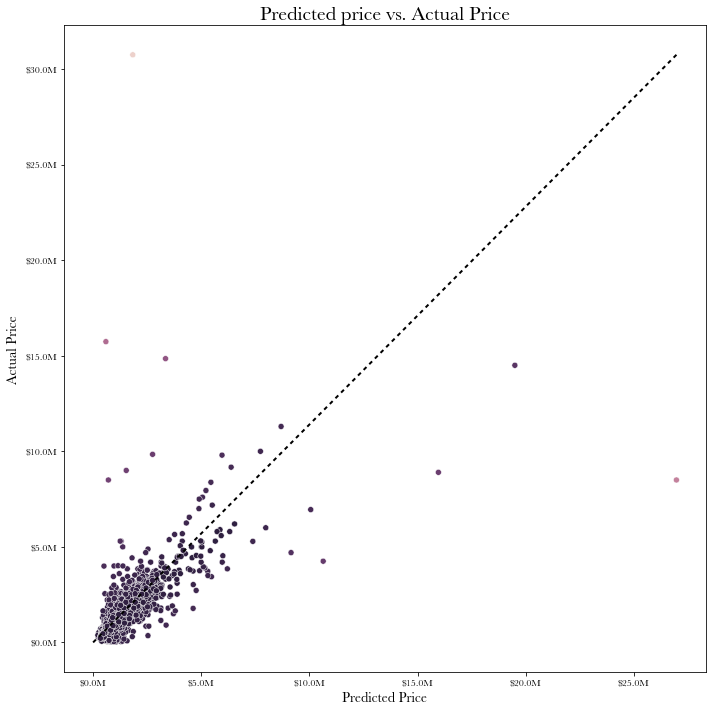

In [1141]:
predicted = np.exp(predicted)
expected = np.exp(expected)

fig, ax = plt.subplots(figsize=(10, 10))
# sns.jointplot(x= 'actual',y= 'resid', data=y_df).set()
sns.scatterplot(x=predicted.flatten(),y=expected.flatten(), hue=-np.abs(predicted-expected).flatten())
ax.legend([],[], frameon=False)
plt.xlabel('Predicted Price', fontdict={'fontfamily':'Baskerville',
                                        'fontsize':14,
                                        'fontweight':'bold'})
plt.ylabel('Actual Price', fontdict={'fontfamily':'Baskerville',
                                     'fontsize':14,
                                     'fontweight':'bold'})
plt.title('Predicted price vs. Actual Price', fontdict={'fontfamily':'Baskerville',
                                                        'fontsize':20,
                                                        'fontweight':'bold'})
plt.xticks(fontfamily='Baskerville')
plt.yticks(fontfamily='Baskerville')
formatter = ticker.FuncFormatter(lambda x, pos: '$%1.1fM' % (x * 1e-6))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
plt.plot([0, max(predicted)], [0, max(expected)], linewidth=2, color='black', dashes=[2,2])
plt.tight_layout()

plt.savefig('imgs/final_resid_456.png')
plt.show()